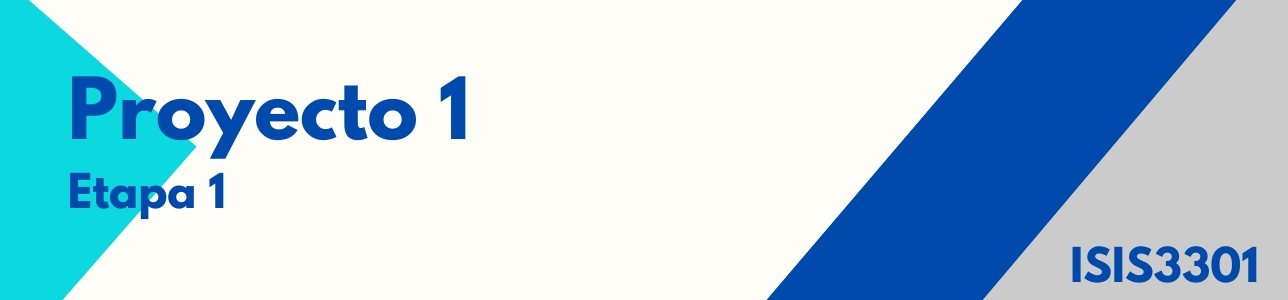

### Instalación e importación de librerías

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Instalación de librerias
import pandas as pd
import numpy as np
from collections import Counter
import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install langdetect
from langdetect import detect
from nltk.stem import SnowballStemmer
#from pandas_profiling import ProfileReport
import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SpanishStemmer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

#1. Entendimiento y preparación de los datos.


##1.1. Entendimiento de los datos.

In [6]:
ODS_df = pd.read_csv('ODScat_345.csv', sep=',', encoding = 'UTF-8')
ODS_df.shape

(4049, 2)

In [7]:
ODS_df.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


In [8]:
ODS_df.dtypes

,0
Textos_espanol,object
sdg,int64


In [9]:
from scipy import stats as st

copia = ODS_df.copy()
copia['Conteo'] = [len(x) for x in copia['Textos_espanol']]
copia['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in copia['Textos_espanol']]
copia['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in copia['Textos_espanol']]

#ProfileReport(copia)

In [10]:
ODS_df["Textos_espanol"] = ODS_df["Textos_espanol"].astype(str)

In [11]:
pd.value_counts(ODS_df['sdg'])

<ipython-input-11-84d88a4c189a>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(ODS_df['sdg'])


,count
sdg,
5,1451
4,1354
3,1244


Podemos evidenciar que las 3 categorías tienen un tamaño muy similar, por lo que podemos descartar errores por desbalance de las categorías.

In [12]:
ODS_df.isnull().sum()

,0
Textos_espanol,0
sdg,0


In [13]:
ODS_df.isna().sum()

,0
Textos_espanol,0
sdg,0


Los datos están completos.

##1.2. Preparación de los datos.

In [14]:
ODS_df['Longitud_del_mensaje'] = ODS_df['Textos_espanol'].str.len()

IRQ = np.percentile(ODS_df['Longitud_del_mensaje'], 75) - np.percentile(ODS_df['Longitud_del_mensaje'], 25)
threshold = np.percentile(ODS_df['Longitud_del_mensaje'], 75) + 1.5*IRQ
ODS_df = ODS_df[ODS_df['Longitud_del_mensaje'] < threshold]


Se eliminan los textos que son atípicamente largos.

In [15]:
ODS_df["Pais"] = ODS_df["Textos_espanol"].apply(lambda x: detect(x))
ODS_df = ODS_df[ODS_df["Pais"] == "es"]

Se eliminan los textos que no están en español.

In [16]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
      new_words.append(word.lower())
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def remove_tildes(words):
  new_words = []
  for word in words:
    new_words.append(unicodedata.normalize ('NFKD', word).encode ('ascii', 'ignore').decode ('utf-8', 'ignore'))
  return new_words

def replace_numbers(words):
    p = inflect.engine()
    print(words)
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
            print("if " + new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
  """Remove stop words from list of tokenized words"""
  stop = set(stopwords.words("spanish"))
  new_words = []
  for word in words:
    if word not in stop:
      new_words.append(word)
  return new_words

def preprocessing(words):
    words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_tildes(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [17]:
ODS_df['Tokens_textos'] = ODS_df['Textos_espanol'].apply(word_tokenize)
ODS_df.head()

,Textos_espanol,sdg,Longitud_del_mensaje,Pais,Tokens_textos
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,944,es,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...",3,476,es,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,1207,es,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,1090,es,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,895,es,"[El, consumo, anual, de, alcohol, se, estima, ..."


Aplicamos la tokenización de los comentarios.

In [18]:
ODS_df['Tokens_textos'].dropna()

,Tokens_textos
0,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"[El, consumo, anual, de, alcohol, se, estima, ..."
...,...
4044,"[Para, ello, ,, identificará, las, cuestiones,..."
4045,"[La, participación, de, las, mujeres, en, role..."
4046,"[Según, el, WEF, ,, según, las, tendencias, de..."
4047,"[Sirve, como, recurso, y, foro, para, las, age..."


Se eliminan los campos de texto vacíos.

In [19]:
ODS_df.shape

(3941, 5)

In [20]:
ODS_df["Tokens_textos"]=ODS_df['Tokens_textos'].apply(preprocessing)

In [21]:
ODS_df["Tokens_textos"].sample(10)

,Tokens_textos
558,"[titulares, derechos, pueden, otorgar, licenci..."
456,"[segun, respuestas, encuestas, caracteristicas..."
2979,"[desafios, ven, magnificados, altas, tasas, in..."
733,"[idea, emparejar, personas, comparables, funci..."
3253,"[queda, hacer, eliminar, prejuicios, genero, a..."
2786,"[mujeres, ninas, menos, oportunidades, educati..."
1126,"[educacion, atencion, primera, infancia, casi,..."
1084,"[estimacion, comun, mas, 80, ciento, habitante..."
1147,"[mayoria, curriculos, nacionales, incluyen, ma..."
1860,"[unicos, profesores, da, opcion, incorporarse,..."


Se aplica exitosamente todo el preprocesamiento de las palabras para eliminar caracteres ASCII no reconocidos, signos de puntuación, tildes y StopWords.

In [22]:
def stem_words(words):
  """Stem words in list of tokenized words"""
  new_words = []
  stemmer = SpanishStemmer()
  for word in words:
    new_words.append(stemmer.stem(word))
  return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""

def stem_and_lemmatize(words):
    stems = stem_words(words)
#    lemmas = lemmatize_verbs(words)
#    return stems + lemmas
    return stems

In [23]:
ODS_df["Tokens_textos"]=ODS_df['Tokens_textos'].apply(stem_and_lemmatize)

In [24]:
ODS_df["Tokens_textos"].sample(10)

,Tokens_textos
2275,"[fundamental, establec, relacion, perspect, ge..."
2052,"[much, mujer, miembr, depend, mar, deb, falt, ..."
2781,"[form, profesional, sanitari, apoy, unfpa, uni..."
652,"[sol, entonc, promes, merc, regional, brind, i..."
3930,"[embarg, intervencion, seri, mas, facil, ampli..."
1533,"[lider, centr, defin, person, mayor, respons, ..."
1520,"[austri, introduj, exam, simil, lehr, mit, mat..."
2340,"[factor, contribu, brech, gener, relat, ampli,..."
1611,"[reduccion, curricul, llev, dediqu, mas, tiemp..."
1684,"[abord, result, educ, grup, analiz, principal,..."


In [25]:
def join_words(words:list):
  new_str = ""
  for word in words:
    new_str += word + " "
  return new_str
ODS_df["Tokens_a_texto"] = ODS_df["Tokens_textos"].apply(lambda x: join_words(x))
ODS_df["Tokens_a_texto"].sample(10)

,Tokens_a_texto
3477,dos aspect principal relacion fuerz pendient g...
1746,embarg inform oportun educ dispon joven hoy pu...
3524,eleccion mujer gobiern local urban aument resp...
1590,enmiend ley educ escol 2011 hiz obligatori asi...
3938,core reduc cost compart atencion inclu product...
2892,baj nivel imposit perjudic pobr mujer pobr par...
2661,ocde llev cab ampli investig emple remuner muj...
3149,encuest inclu seri pregunt cuestion financi es...
2138,mayor diferent lfpr mujer hombr encuentr grup ...
1707,longitud total barr indic variacion observ ind...


In [26]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(ODS_df['Tokens_a_texto'])
palabras = vectorizer.get_feature_names_out()  # Obtiene las palabras (columnas)
r = pd.DataFrame(X.toarray(), columns=palabras)

r.shape

(3941, 11409)

In [27]:
r.head()

,000,001,003,004,005,006,007,008,009,01,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
ODS_df = ODS_df.join(r)

In [29]:
ODS_df.dtypes

,0
Textos_espanol,object
sdg,int64
Longitud_del_mensaje,int64
Pais,object
Tokens_textos,object
...,...
zonmw,float64
zuck,float64
zukowski,float64
zupanc,float64


In [30]:
number_cols = ODS_df.select_dtypes(include = ['int64','float64']).columns
ODS_df[number_cols].mean().sort_values(ascending = False)

,0
Longitud_del_mensaje,684.690180
sdg,4.048211
mujer,0.726231
mas,0.679083
educ,0.523053
...,...
pospart,0.000000
itp,0.000000
itiner,0.000000
heckert,0.000000


In [31]:
eliminar = ['Longitud_del_mensaje','Pais', 'Textos_espanol', 'Tokens_textos', 'Tokens_a_texto']
ODS_df = ODS_df.drop(eliminar,axis=1)
ODS_df.sample(3)

,sdg,000,001,003,004,005,006,007,008,009,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
2256,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2224,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#ODS_df.to_csv('ods_limpios.csv')

# Implementación Naive Bayes Multinomial

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [34]:
ODS_df.shape

(3941, 11410)

Eliminación de valores nulos o NaN

In [35]:
ODS_df = ODS_df.dropna()

In [36]:
x = ODS_df.drop(columns="sdg")
y = ODS_df["sdg"]

In [37]:
ODS_df.shape

(3839, 11410)

Se entrena con 102 menos entradas que las dadas inicialmente

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [39]:
nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

MultinomialNB()

In [40]:
y_pred = nb_model.predict(X_test)

In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report


print('exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("recall: {}".format(recall_score(y_test, y_pred, average="macro")))
print("precision: {}".format(precision_score(y_test, y_pred, average="macro")))
print("puntuacion f1: {}".format(f1_score(y_test, y_pred, average="macro")))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

exactitud: 0.80
recall: 0.7959658145016401
precision: 0.7976946550891523
puntuacion f1: 0.796512718144149
Confusion Matrix:
 [[256  25  34]
 [ 17 255  52]
 [ 30  38 253]]


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.84      0.81      0.83       315
           4       0.80      0.79      0.79       324
           5       0.75      0.79      0.77       321

    accuracy                           0.80       960
   macro avg       0.80      0.80      0.80       960
weighted avg       0.80      0.80      0.80       960



In [43]:
import pandas as pd

correlation_matrix = ODS_df.corr()

target_corr = correlation_matrix['sdg'].sort_values(ascending=False)

In [45]:
print(target_corr.head(10))

sdg         1.000000
mujer       0.409823
gener       0.291870
hombr       0.231446
iguald      0.212135
trabaj      0.173506
muj         0.172056
derech      0.164615
violenci    0.152168
remuner     0.144404
Name: sdg, dtype: float64
